In [ ]:
import torch
from torch import nn,optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import wandb

In [ ]:
# prepare the dataset


# setup transform
tranform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.4)
])

train_data = datasets.MNIST(root='data/',train=True, transform=tranform,download=True)
test_data = datasets.MNIST(root='data/',train=False, transform=tranform, download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.56MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.2MB/s]


Text(0.5, 1.0, 'This is an image of the number 7')

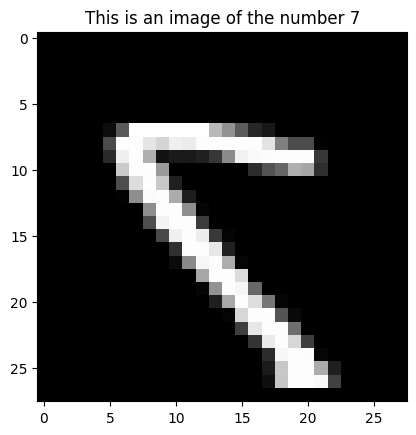

In [ ]:
plt.imshow(np.transpose(train_data[617][0], (1,2,0)), cmap="grey")
plt.title(f"This is an image of the number {train_data[617][1]}")

In [ ]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
# define the network

class Digit_NN(nn.Module):

  def __init__(self) -> None:
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding = 1) # 32 by 28 by 28
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding = 1) # 64 by 28 by 28
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 64 by 14 by 14
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=64*7*7, out_features=1000)
    self.fc2 = nn.Linear(in_features=1000, out_features=250)
    self.out = nn.Linear(in_features=250, out_features=10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.4)


  def forward(self, X:torch.Tensor) -> torch.Tensor:
    result = self.relu(self.conv1(X)) # 32 by 28 by 28
    result = self.pool(result)  # 32 by 14 by 14
    result = self.relu(self.conv2(result)) # 64 by 14 by 14
    result = self.pool(result) #64 by 7 by 7
    result = self.flatten(result)
    result = self.dropout(self.relu(self.fc1(result)))
    result = self.dropout(self.relu(self.fc2(result)))

    return self.out(result)

In [ ]:
# init the model and the model hyperparams

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Digit_NN().to(device)
lr = 2e-5
optimizer = optim.AdamW(params = model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
batch_size = 32
epochs = 10

In [ ]:
run = wandb.init(
    project= "MNIST DIGIT RECOGNITION WITH CUSTOM CNN",
    config = {
        'model_type': "Custom CNN",
        'learning rate': lr,
        'optimizer': 'AdamW',
        'Optimizer Params': {"weight_decay": 0.01},
        'criterion': 'cross_entropy_loss',
        'batch_size': batch_size,
        'epochs': epochs
    })

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: salamichino (salamichino-appclick) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# setup dataloader

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# setup the training and validation loop

overall_train_loss = []
overall_test_loss = []
for epoch in range(epochs):
  model.train()
  epoch_labels = []
  epoch_preds = []
  epoch_test_labels = []
  epoch_test_preds = []
  epoch_train_loss = []
  epoch_test_loss = []
  train_batch = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}...")
  for image, label in train_batch:
    image, label = image.to(device), label.to(device)
    train_preds = model(image)
    loss = criterion(train_preds, label)

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_train_loss.append(loss.item())
    epoch_labels.extend(label.detach().cpu().numpy())
    logit, preds = torch.max(train_preds, 1)
    epoch_preds.extend(preds.detach().cpu().numpy())

  # compute metrics
  train_loss = sum(epoch_train_loss)/len(epoch_train_loss)
  train_f1 = f1_score(epoch_labels, epoch_preds, average = "weighted")
  print(f"Training Completed.....")

  # evaluation loop
  model.eval()
  with torch.no_grad():
    test_batch = tqdm(test_loader, desc=f"Testing epoch {epoch + 1}/ {epochs}")
    for image, label in test_batch:
      image, label = image.to(device), label.to(device)
      test_preds = model(image)
      loss_test = criterion(test_preds, label)

      # get all the needed result

      epoch_test_loss.append(loss_test.item())
      epoch_test_labels.extend(label.detach().cpu().numpy())
      logit, preds = torch.max(test_preds, 1)
      epoch_test_preds.extend(preds.detach().cpu().numpy())

  #compute the test metrics
  test_loss = sum(epoch_test_loss)/len(epoch_test_loss)
  test_f1 = f1_score(epoch_test_labels, epoch_test_preds, average = "weighted")

  epoch_result = {
      'epoch': epoch + 1,
      'train_loss': train_loss,
      'test_loss': test_loss,
      'test_f1': test_f1,
      'train_f1': train_f1
  }
  print(f"Test Completed with result: {epoch_result}")
  run.log(data = epoch_result)


run.finish()

Training Epoch 1/10...: 100%|██████████| 1875/1875 [00:19<00:00, 97.22it/s] 


Training Completed.....


Testing epoch 1/ 10: 100%|██████████| 313/313 [00:01<00:00, 170.45it/s]


Test Completed with result: {'epoch': 1, 'train_loss': 1.1335436443010967, 'test_loss': 0.524535735146687, 'test_f1': 0.8296178247984181, 'train_f1': 0.6320551784780852}


Training Epoch 2/10...: 100%|██████████| 1875/1875 [00:19<00:00, 96.07it/s]


Training Completed.....


Testing epoch 2/ 10: 100%|██████████| 313/313 [00:02<00:00, 133.66it/s]


Test Completed with result: {'epoch': 2, 'train_loss': 0.5317908682743708, 'test_loss': 0.3741768312435181, 'test_f1': 0.8724893027152564, 'train_f1': 0.8238903962293765}


Training Epoch 3/10...: 100%|██████████| 1875/1875 [00:18<00:00, 101.93it/s]


Training Completed.....


Testing epoch 3/ 10: 100%|██████████| 313/313 [00:01<00:00, 174.38it/s]


Test Completed with result: {'epoch': 3, 'train_loss': 0.4077749250570933, 'test_loss': 0.29460092792257714, 'test_f1': 0.9021291752618823, 'train_f1': 0.8654523822793846}


Training Epoch 4/10...: 100%|██████████| 1875/1875 [00:17<00:00, 104.89it/s]


Training Completed.....


Testing epoch 4/ 10: 100%|██████████| 313/313 [00:01<00:00, 176.21it/s]


Test Completed with result: {'epoch': 4, 'train_loss': 0.33365185080567994, 'test_loss': 0.24572626195443323, 'test_f1': 0.9196929595909196, 'train_f1': 0.8897716595124091}


Training Epoch 5/10...: 100%|██████████| 1875/1875 [00:17<00:00, 108.64it/s]


Training Completed.....


Testing epoch 5/ 10: 100%|██████████| 313/313 [00:01<00:00, 175.23it/s]


Test Completed with result: {'epoch': 5, 'train_loss': 0.2798469909568628, 'test_loss': 0.19859657077172313, 'test_f1': 0.9363017960104906, 'train_f1': 0.9102591636563769}


Training Epoch 6/10...: 100%|██████████| 1875/1875 [00:18<00:00, 101.28it/s]


Training Completed.....


Testing epoch 6/ 10: 100%|██████████| 313/313 [00:01<00:00, 177.60it/s]


Test Completed with result: {'epoch': 6, 'train_loss': 0.23685363364120324, 'test_loss': 0.16823375135802995, 'test_f1': 0.9468369287327565, 'train_f1': 0.9242913633561407}


Training Epoch 7/10...: 100%|██████████| 1875/1875 [00:17<00:00, 108.81it/s]


Training Completed.....


Testing epoch 7/ 10: 100%|██████████| 313/313 [00:01<00:00, 171.06it/s]


Test Completed with result: {'epoch': 7, 'train_loss': 0.20602763190915188, 'test_loss': 0.14267041231282412, 'test_f1': 0.9555864100648512, 'train_f1': 0.934653945416759}


Training Epoch 8/10...: 100%|██████████| 1875/1875 [00:17<00:00, 104.97it/s]


Training Completed.....


Testing epoch 8/ 10: 100%|██████████| 313/313 [00:01<00:00, 175.92it/s]


Test Completed with result: {'epoch': 8, 'train_loss': 0.17992676573793093, 'test_loss': 0.13091330511715657, 'test_f1': 0.9591488203051669, 'train_f1': 0.9440338316527968}


Training Epoch 9/10...: 100%|██████████| 1875/1875 [00:17<00:00, 108.99it/s]


Training Completed.....


Testing epoch 9/ 10: 100%|██████████| 313/313 [00:02<00:00, 140.56it/s]


Test Completed with result: {'epoch': 9, 'train_loss': 0.16214663452208042, 'test_loss': 0.11062614841404529, 'test_f1': 0.966550751865852, 'train_f1': 0.9501453527377592}


Training Epoch 10/10...: 100%|██████████| 1875/1875 [00:17<00:00, 107.89it/s]


Training Completed.....


Testing epoch 10/ 10: 100%|██████████| 313/313 [00:01<00:00, 177.41it/s]


Test Completed with result: {'epoch': 10, 'train_loss': 0.14631737879614035, 'test_loss': 0.10408063267860503, 'test_f1': 0.966990572939137, 'train_f1': 0.9545533094087804}


epoch,▁▂▃▃▄▅▆▆▇█
test_f1,▁▃▅▆▆▇▇███
test_loss,█▅▄▃▃▂▂▁▁▁
train_f1,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
test_f1,0.96699
test_loss,0.10408
train_f1,0.95455
train_loss,0.14632
